In [1]:
%run ../StatTest2_WithSimulation_Setup.ipynb

{0: ['ME', 'IL', 'PA', 'GA', 'OK', 'DE', 'WA', 'CT', 'OH', 'VA', 'NE', 'MT', 'IN', 'CA', 'HI', 'ND', 'MD', 'SC', 'RI', 'AK', 'KY', 'WI', 'LA', 'MN', 'MS', 'WV', 'FL'], 1: ['SD', 'IL', 'PA', 'NH', 'NM', 'NV', 'OK', 'UT', 'CT', 'OH', 'VA', 'OR', 'CO', 'IN', 'HI', 'AL', 'RI', 'AK', 'LA', 'MN', 'IA', 'AR', 'WV'], 2: ['MI', 'ME', 'WY', 'DC', 'TX', 'AZ', 'NC', 'WA', 'OR', 'CO', 'MT', 'ND', 'TN', 'SC', 'AL', 'NY', 'KY', 'NJ', 'KS', 'ID', 'IA', 'AR', 'MO'], 3: ['MI', 'SD', 'WY', 'NH', 'DC', 'TX', 'GA', 'AZ', 'NM', 'NC', 'NV', 'DE', 'UT', 'NE', 'CA', 'MD', 'TN', 'NY', 'NJ', 'KS', 'WI', 'ID', 'MS', 'FL', 'MO']}
{0: ['MI', 'SD', 'WY', 'NH', 'DC', 'TX', 'AZ', 'NM', 'NC', 'NV', 'UT', 'OR', 'CO', 'TN', 'AL', 'NY', 'NJ', 'KS', 'ID', 'IA', 'AR', 'MO'], 1: ['MI', 'ME', 'WY', 'DC', 'TX', 'GA', 'AZ', 'NC', 'DE', 'WA', 'NE', 'MT', 'CA', 'ND', 'MD', 'TN', 'SC', 'NY', 'KY', 'NJ', 'KS', 'WI', 'ID', 'MS', 'FL', 'MO'], 2: ['SD', 'IL', 'PA', 'NH', 'GA', 'NM', 'NV', 'OK', 'DE', 'UT', 'CT', 'OH', 'VA', 'NE', 'IN'

In [2]:
###################
# LOCAL VARIABLES #
###################

states = ['CA']
state_label = "CA"
file_label = "CA"
t_file = "npy/" + file_label + "_simulated_transfers.npy"
d_file = "npy/" + file_label + "_simulated_transfers_over_sqrtn.npy"
big_j = 10**5

beta_from_ks = 85960

In [3]:
data2014 = pd.read_csv("../0-Our_Dataset/2014dataset.csv")
data2015 = pd.read_csv("../0-Our_Dataset/2015dataset.csv")
data2016 = pd.read_csv("../0-Our_Dataset/2016dataset.csv")
data2017 = pd.read_csv("../0-Our_Dataset/2017dataset.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,52,323,649,882,932,1092,1202) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,57,204,341,376,377,396,430,431,928,944,1006,1013,1151,1160,1169,1179,1411) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,17,163,355,406,702,835,847,1083,1156,1183,1185,1200) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Create the labels.
# By index:
# label 2 is transfers
# label 3 is premiums
# label 4 is costs
# label 5 is member months
# label 6 is reinsurance (individual group only)

ind_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                  "HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)",
                  "1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "STATE", "REINSURANCE PAYMENT AMOUNT (OR NOT ELIGIBLE)"] # no more reinsurance as of 2017
ind_labels_15 = [label.replace('15', '16') for label in ind_labels_14]
ind_labels_16 = [label.replace('15', '17') for label in ind_labels_14]
ind_labels_17 = [label.replace('15', '18') for label in ind_labels_14][:-1]

sg_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                 "HHS RISK ADJUSTMENT TRANSFERS AMOUNT (SMALL GROUP MARKET)",
                  "1.1Directpremiumwritten7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "2.16Totalincurredclaims7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "7.4Membermonths7HealthInsuranceSMALLGROUPTotalasof3/31/15", "STATE"]
sg_labels_15 = [label.replace('15', '16') for label in sg_labels_14]
sg_labels_16 = [label.replace('15', '17') for label in sg_labels_14]
sg_labels_17 = [label.replace('15', '18') for label in sg_labels_14]

In [5]:
# Filter the data to include only the fields we want

ind_data_14 = data2014[ind_labels_14].dropna()
ind_data_15 = data2015[ind_labels_15].dropna()
ind_data_16 = data2016[ind_labels_16].dropna()
ind_data_17 = data2017[ind_labels_17].dropna()
sg_data_14 = data2014[sg_labels_14].dropna()
sg_data_15 = data2015[sg_labels_15].dropna()
sg_data_16 = data2016[sg_labels_16].dropna()
sg_data_17 = data2017[sg_labels_17].dropna()

In [6]:
# Drop companies with <2000 MM
ind_data_14 = ind_data_14.where(ind_data_14[ind_labels_14[5]] > 2000).dropna()
ind_data_15 = ind_data_15.where(ind_data_15[ind_labels_15[5]] > 2000).dropna()
ind_data_16 = ind_data_16.where(ind_data_16[ind_labels_16[5]] > 2000).dropna()
ind_data_17 = ind_data_17.where(ind_data_17[ind_labels_17[5]] > 2000).dropna()
sg_data_14 = sg_data_14.where(sg_data_14[sg_labels_14[5]] > 2000).dropna()
sg_data_15 = sg_data_15.where(sg_data_15[sg_labels_15[5]] > 2000).dropna()
sg_data_16 = sg_data_16.where(sg_data_16[sg_labels_16[5]] > 2000).dropna()
sg_data_17 = sg_data_17.where(sg_data_17[sg_labels_17[5]] > 2000).dropna()

In [7]:
# Calculate transfers, premiums, costs, and reinsurance (if individual group) per member month
def calculate_pmm(df, df_labels, group):
    df["MM"] = df[df_labels[5]]
    df["Transfers"] = df[df_labels[2]]
    df["TotalCosts"] = abs(df[df_labels[4]])
    df["Enrollees"] = df["MM"] / 12
    df["TransfersPerEnrollee"] = df["Transfers"] / df["Enrollees"]
    df["TransfersPerSqrtEnrollee"] = df["Transfers"] / np.sqrt(df["Enrollees"])
    df["LogEnrollees"] = np.log(df["Enrollees"])
    df["LogTransfers"] = np.log(df["Transfers"]**2 + 1)
    df["TransfersPMM"] = df[df_labels[2]] / df[df_labels[5]]
    df["PremiumsPMM"] = abs(df[df_labels[3]] / df[df_labels[5]])
    df["CostsPMM"] = abs(df[df_labels[4]] / df[df_labels[5]])
    if group == "i":
        df["ReinsurancePMM"] = df[df_labels[7]] / df[df_labels[5]]
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"] + df["ReinsurancePMM"]
        #df["PremMinusCostsPlusReinsurancePMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["ReinsurancePMM"]
    elif group == "sg":
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["PremMinusCostsPMM"] = df["PremiumsPMM"] - df["CostsPMM"]
    df["PremMinusCostsPlusTransfersPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["SicknessPMM"] = df["CostsPMM"] - df["PremiumsPMM"]
    average_sickness = np.mean(df["SicknessPMM"])
    df["ExcessSicknessPMM"] = df["SicknessPMM"] - average_sickness
    return df

ind_data_14 = calculate_pmm(ind_data_14, ind_labels_14, "i")
ind_data_15 = calculate_pmm(ind_data_15, ind_labels_15, "i")
ind_data_16 = calculate_pmm(ind_data_16, ind_labels_16, "i")
ind_data_17 = calculate_pmm(ind_data_17, ind_labels_17, "sg")
sg_data_14 = calculate_pmm(sg_data_14, sg_labels_14, "sg")
sg_data_15 = calculate_pmm(sg_data_15, sg_labels_15, "sg")
sg_data_16 = calculate_pmm(sg_data_16, sg_labels_16, "sg")
sg_data_17 = calculate_pmm(sg_data_17, sg_labels_17, "sg")

In [8]:
# Combine the dataframes by left merging

ind_data = ind_data_14.merge(ind_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(ind_data_16, on='HIOS ID', how='outer').merge(ind_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [9]:
# Do the same thing for small group

sg_data = sg_data_14.merge(sg_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(sg_data_16, on='HIOS ID', how='outer').merge(sg_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [10]:
dfs = [sg_data_14, sg_data_15, sg_data_16, sg_data_17]

In [11]:
dfs_new, empirical_transfers_sum = normalize_empirical_data_to_avg_2017_dollars(dfs, states)

Cbar is 4398.953
CA 14 Ratio is 1.154
CA 15 Ratio is 1.117
CA 16 Ratio is 1.051
CA 17 Ratio is 1.015
Empirical Transfers Sum = 2043400167.669


In [12]:
for df_temp in dfs_new:
    df_temp["TransfersNormalizedPerSqrtEnrollee"] = df_temp["TransfersNormalized"] / np.sqrt(df_temp["Enrollees"])

In [13]:
start_cost_matrix = time.time()

stateyear_to_df = dict()
stateyear_to_random = dict()

c_bar = 4398.953
    
sum_sqrt_a = 0
cost_matrix_sum = 0
df_sum = 0
for current_state in states:
    for df_index in range(4):
        label = current_state + df_index_to_year[df_index]
        this_df = state(dfs[df_index], current_state)
        if len(this_df) > 0:
            sum_n = sum(this_df["Enrollees"])
            this_df["sum_n_minus_n_i"] = sum_n - this_df["Enrollees"]
            this_df["a"] = this_df["Enrollees"] * (this_df["sum_n_minus_n_i"] / sum_n)**2 + this_df["sum_n_minus_n_i"] * (this_df["Enrollees"] / sum_n)**2
            this_df["sqrt_a"] = np.sqrt(this_df["a"])
            c_stateyear = sum(this_df["TotalCosts"]) / sum(this_df["Enrollees"])
            
            cost_matrix = [np.random.normal(0, sqrta, 10**5) for sqrta in this_df["sqrt_a"]]
            cost_matrix = np.array(cost_matrix) * c_bar / c_stateyear
            
            cost_matrix_sum = cost_matrix_sum + len(cost_matrix)
            df_sum = df_sum + len(this_df["sqrt_a"])
            sum_sqrt_a = sum_sqrt_a + sum(this_df["sqrt_a"])
            stateyear_to_df[label] = this_df
            stateyear_to_random[label] = np.array(cost_matrix)
end_cost_matrix = time.time()
            
print(cost_matrix_sum)
print(df_sum)
print("Executed in %.3f s" % (end_cost_matrix - start_cost_matrix))

61
61
Executed in 0.692 s


In [14]:
lab = "TransfersNormalizedPerSqrtEnrollee"


abs_empirical_di = np.absolute(np.concatenate((np.array(dfs_new[0][lab]),
                                               np.array(dfs_new[1][lab]),
                                               np.array(dfs_new[2][lab]),
                                               np.array(dfs_new[3][lab]))))
sorted_abs_empirical_di = np.sort(abs_empirical_di)

In [15]:
beta = 40000
pval = 0.01
k = len(sorted_abs_empirical_di)
all_transfers, all_di = apr_test_imbalances_2017_NEW(stateyear_to_df, stateyear_to_random, beta, k, big_j)

0 iterations completed in 0.0 s
10000 iterations completed in 26.9 s
20000 iterations completed in 27.1 s
30000 iterations completed in 25.9 s
40000 iterations completed in 26.0 s
50000 iterations completed in 25.2 s
60000 iterations completed in 27.6 s
70000 iterations completed in 27.1 s
80000 iterations completed in 27.4 s
90000 iterations completed in 25.3 s


In [16]:
np.save(t_file, all_transfers[0:1000])
np.save(d_file, all_di[0:1000])

In [17]:
simulated_transfers = all_transfers
simulated_di = all_di

In [18]:
percentile_idx = int(len(sorted_abs_empirical_di) * 0.10)
p10empirical = sorted_abs_empirical_di[percentile_idx]
print("P10Empirical = %.3f" % (p10empirical))

percentile_idx = int(len(sorted_abs_empirical_di) * 0.15)
p15empirical = sorted_abs_empirical_di[percentile_idx]
print("P15Empirical = %.3f" % (p15empirical))

percentile_idx = int(len(sorted_abs_empirical_di) * 0.2)
p20empirical = sorted_abs_empirical_di[percentile_idx]
print("P20Empirical = %.3f" % (p20empirical))

P10Empirical = 8121.811
P15Empirical = 10122.066
P20Empirical = 11346.572


In [19]:
abs_simulated_di = np.absolute(simulated_di)  
sorted_abs_simulated_di = np.sort(abs_simulated_di, axis=1)

In [20]:
def calculate_beta_from_x(x):
    percentile_idx = int(k * x)
    px_empirical = sorted_abs_empirical_di[percentile_idx]
    pxs = sorted_abs_simulated_di[:,percentile_idx]
    sorted_pxs = np.sort(pxs)
    px_idx = int((pval)*big_j)
    qx = sorted_pxs[px_idx]
    beta = px_empirical * 40000 / qx
    print("x = %.2f, beta = %.3f" % (x, beta))
    return beta

In [21]:
xs = [0.1, 0.125, 0.15, 0.175, 0.2]
min_beta = 100000
min_x = 0
for x in xs:
    beta = calculate_beta_from_x(x)
    if beta < min_beta:
        min_beta = beta
        min_x = x

x = 0.10, beta = 158285.328
x = 0.12, beta = 136677.810
x = 0.15, beta = 110328.812
x = 0.17, beta = 101582.478
x = 0.20, beta = 82054.027


In [22]:
df2 = create_df2(states, dfs_new, "TransfersNormalizedPerSqrtEnrollee")
k = len(df2)
v = np.linspace(0, max(abs(df2)), 10000)
v = v[1:len(v)]

ratios = [ratio_list(df2, vi) for vi in v]
begin_p = 5/k
end_p = 1-begin_p
start_index = 0
end_index = 0
for index, ratio2 in enumerate(ratios):
    if ratio2 >= begin_p:
        start_index = index
        break
    
for index, ratio2 in enumerate(ratios):
    if ratio2 > end_p:
        end_index = index
        break

if end_index == 0:
    end_index = len(v) - 1
    
v = v[start_index:end_index]

ratios2 = ratios[start_index:end_index]
ratios_sim1 = [ratio_list(all_di[0] * min_beta / 40000, vi) for vi in v]
ratios_sim2 = [ratio_list(all_di[1] * min_beta / 40000, vi) for vi in v]
ratios_sim3 = [ratio_list(all_di[2] * min_beta / 40000, vi) for vi in v]

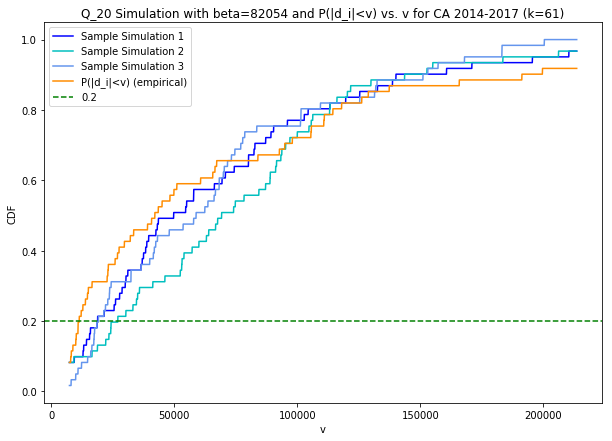

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(v, ratios_sim1, label="Sample Simulation 1", color='b')
plt.plot(v, ratios_sim2, label="Sample Simulation 2", color='c')
plt.plot(v, ratios_sim3, label="Sample Simulation 3", color='cornflowerblue')
plt.plot(v, ratios2, label="P(|d_i|<v) (empirical)", color='darkorange')
plt.title("Q_%d Simulation with beta=%d and P(|d_i|<v) vs. v for %s 2014-2017 (k=%d)" % (min_x * 100, min_beta, state_label, len(df2)))
plt.xlabel("v")
plt.ylabel("CDF")
plt.axhline(y=min_x, color='g', linestyle='--', label=str(min_x))
plt.legend()
plt.show()

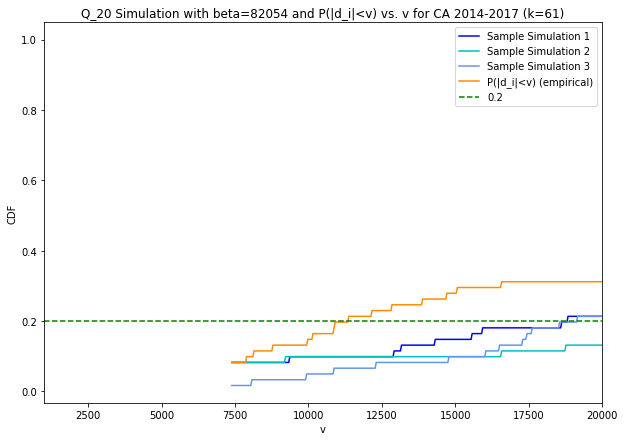

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(v, ratios_sim1, label="Sample Simulation 1", color='b')
plt.plot(v, ratios_sim2, label="Sample Simulation 2", color='c')
plt.plot(v, ratios_sim3, label="Sample Simulation 3", color='cornflowerblue')
plt.plot(v, ratios2, label="P(|d_i|<v) (empirical)", color='darkorange')
plt.title("Q_%d Simulation with beta=%d and P(|d_i|<v) vs. v for %s 2014-2017 (k=%d)" % (min_x * 100, min_beta, state_label, len(df2)))
plt.axhline(y=min_x, color='g', linestyle='--', label=str(min_x))
plt.legend()
plt.xlim((1000, 20000))
plt.xlabel("v")
plt.ylabel("CDF")
plt.show()

In [25]:
run_binom_stat_test2(min_beta, df2.values)

Beta (=std): 82054
Number of T/sqrt(n) above 2 stds: 8
Proportion of T/sqrt(n) above 2 stds: 0.131
P value = 0.001693


In [26]:
# Because we're only doing this for one state, we have to use
# the beta from the KS Test, beta_from_ks

print("Sum of Empirical Transfers")
print("%.3f" % (empirical_transfers_sum))

print("Average Sum of Simulated Transfers")
simulated_transfers_sum = np.mean(np.sum(np.absolute(simulated_transfers * beta_from_ks / 40000), axis=1))
print("%.3f" % (simulated_transfers_sum))

print("Empirical/Simulated Ratio")
print("%.3f" % (empirical_transfers_sum / simulated_transfers_sum))

Sum of Empirical Transfers
2043400167.669
Average Sum of Simulated Transfers
1105995454.706
Empirical/Simulated Ratio
1.848


In [27]:
sum_sqrt_a * beta_from_ks * np.sqrt(2) / np.sqrt(np.pi)

1023344970.8173031

In [28]:
sum_sqrt_a

14920.576073476543